In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from scipy.stats import pearsonr

In [8]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 800, 16): #1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor
    
print(len(c2pt))

28672


In [9]:
features = np.array([np.array([ts[i], taus[i], xs[i], ys[i], zs[i], c2pt[i][0], c2pt[i][1]]) for i in range(len(ts))])

labels_S = np.array([np.array([c3pt_S[i][0], c3pt_S[i][1]]) for i in range(len(c3pt_S))])
labels_A = np.array([np.array([c3pt_A[i][0], c3pt_A[i][1]]) for i in range(len(c3pt_A))])
labels_V = np.array([np.array([c3pt_V[i][0], c3pt_V[i][1]]) for i in range(len(c3pt_V))])

print(len(features))
print(len(features[0]))
print(len(labels_S))
print(len(labels_A))
print(len(labels_V))

28672
7
28672
28672
28672


In [4]:
corrs_S = []
corrs_A = []
corrs_V = []

c2pt_chunk = []
c3pt_S_chunk = []
c3pt_A_chunk = []
c3pt_V_chunk = []
c2pt_OTHER_chunk = []
for i in range(len(features)):
    t = int(features[i, 0])
    tau = int(features[i, 1])
    if (t - tau + 64) % 64 > 8:
        continue
    else:
        c2pt_chunk.append(features[i, 5] + 1j * features[i, 6])
        c3pt_S_chunk.append(labels_S[i, 0] + 1j * labels_S[i, 1])
        c3pt_A_chunk.append(labels_A[i, 0] + 1j * labels_A[i, 1])
        c3pt_V_chunk.append(labels_V[i, 0] + 1j * labels_V[i, 1])
        c2pt_OTHER_chunk.append(c2pt_OTHER[i][0] + 1j * c2pt_OTHER[i][0])


In [5]:
corr_S, _ = pearsonr(c2pt_chunk, c3pt_S_chunk)
corr_A, _ = pearsonr(c2pt_chunk, c3pt_A_chunk)
corr_V, _ = pearsonr(c2pt_chunk, c3pt_V_chunk)
corr_2, _ = pearsonr(c2pt_chunk, c2pt_OTHER_chunk)

print(np.sqrt(np.abs(corr_2)))


corrs_S.append(np.sqrt(np.abs(corr_S)))
corrs_A.append(np.sqrt(np.abs(corr_A)))
corrs_V.append(np.sqrt(np.abs(corr_V)))

C:\Users\jjjkr\Anaconda3\lib\site-packages\scipy\stats\stats.py:3555: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))


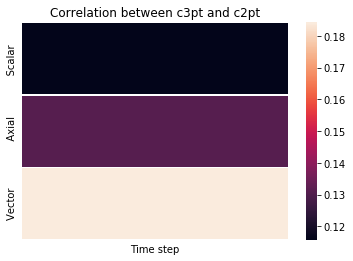

In [6]:
data = np.array([corrs_S, corrs_A, corrs_V])
ax = sns.heatmap(data, linewidth=0.5, yticklabels=False, xticklabels=False)
plt.ylabel("Vector               Axial             Scalar")
plt.title("Correlation between c3pt and c2pt")
plt.xlabel("Time step")
plt.show()